In [35]:
import cv2
import re
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Load data, display column names and dataset size

In [98]:
df = pd.read_csv('heart.csv')
print(f'Dataset size: {df.shape}')
df.head()

Dataset size: (303, 14)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Work out gaps

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


#### Normalize the data

In [100]:
scaler = preprocessing.MinMaxScaler()
columns_names = df.columns
dt_transform = scaler.fit_transform(df)
scaled_dataset = pd.DataFrame(dt_transform, columns=columns_names)
scaled_dataset.head(100)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,0.708333,1.0,1.000000,0.481132,0.244292,1.0,0.0,0.603053,0.0,0.370968,0.0,0.00,0.333333,1.0
1,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.5,0.885496,0.0,0.564516,0.0,0.00,0.666667,1.0
2,0.250000,0.0,0.333333,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,0.00,0.666667,1.0
3,0.562500,1.0,0.333333,0.245283,0.251142,0.0,0.5,0.816794,0.0,0.129032,1.0,0.00,0.666667,1.0
4,0.583333,0.0,0.000000,0.245283,0.520548,0.0,0.5,0.702290,1.0,0.096774,1.0,0.00,0.666667,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.500000,1.0,0.000000,0.452830,0.228311,0.0,0.0,0.305344,1.0,0.000000,1.0,0.00,1.000000,1.0
96,0.687500,0.0,0.000000,0.433962,0.611872,0.0,0.0,0.656489,0.0,0.193548,0.5,0.00,0.666667,1.0
97,0.479167,1.0,0.000000,0.132075,0.244292,1.0,0.5,0.580153,0.0,0.016129,1.0,0.75,1.000000,1.0
98,0.291667,1.0,0.666667,0.339623,0.431507,0.0,0.5,0.694656,0.0,0.306452,1.0,0.25,0.666667,1.0


In [101]:
x = scaled_dataset.drop('output', axis=1);
y = scaled_dataset['output'];

In [102]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1. Dimensionality reduction and data visualization

#### PCA

In [103]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(x)
pca_result_df = pd.DataFrame({'pca_1': pca_result[:,0], 'pca_2': pca_result[:,1], 'label': y})


##### PCA result visualization

<Axes: xlabel='pca_1', ylabel='pca_2'>

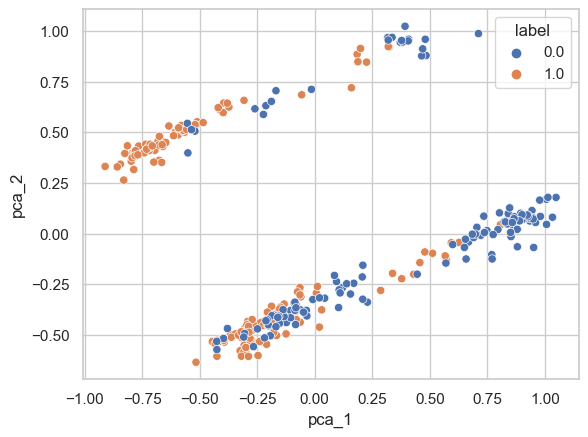

In [104]:
sns.scatterplot(x='pca_1', y='pca_2', hue='label', data=pca_result_df)

#### TSNE

In [105]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(x)
tsne_result_df = pd.DataFrame({'pca_1': tsne_result[:,0], 'pca_2': tsne_result[:,1],'label' : y})

##### TSNE result visualization

<Axes: xlabel='pca_1', ylabel='pca_2'>

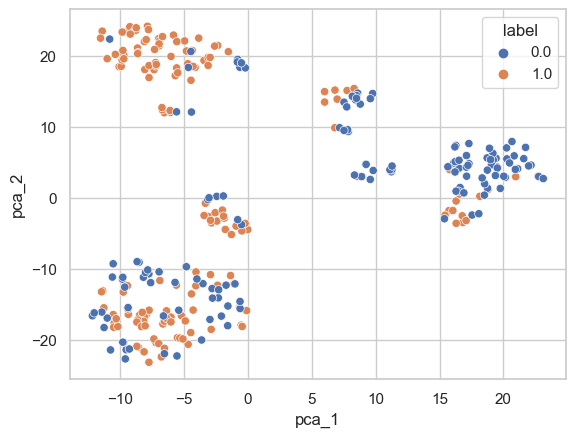

In [106]:
sns.scatterplot(data=tsne_result_df, x='pca_1', y='pca_2', hue='label')

### 2. Cluster analysis

Using the k-means algorithm, perform image quantization (removal of visually redundant information) with a depth of 64, 32, 16 and 8 levels for any self-selected image.

In [119]:
def kmeans_quantization(image, k):
    w, h, d = tuple(image.shape)
    assert d == 3
    image_array = np.reshape(image, (w * h, d))
    
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(image_array)

    cluster_centers = kmeans.cluster_centers_
    # replace each pixel with its corresponding cluster center
    quantized_image = np.reshape(cluster_centers[labels], (w, h, d)) # replace each pixel with its corresponding cluster center
    quantized_image = np.uint8(quantized_image) # convert the quantized image back to uint8 format
    result = cv2.cvtColor(quantized_image, cv2.COLOR_BGR2RGB)

    return result

(-0.5, 3023.5, 4031.5, -0.5)

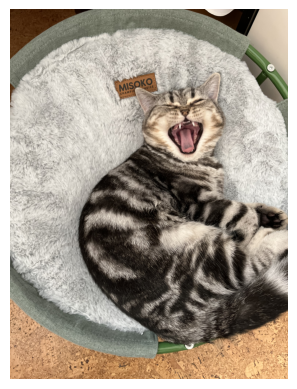

In [120]:
image = cv2.imread("cat.jpeg")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")


#### Image quantization with a depth of 64

(-0.5, 3023.5, 4031.5, -0.5)

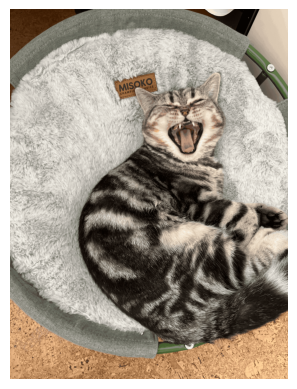

In [121]:
image_64 = kmeans_quantization(image, 64)
plt.imshow(image_64)
plt.axis("off")

#### Image quantization with a depth of 32

(-0.5, 3023.5, 4031.5, -0.5)

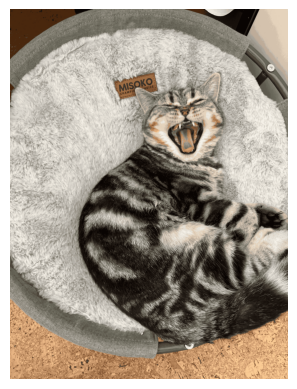

In [122]:
image_32 = kmeans_quantization(image, 32)
plt.imshow(image_32)
plt.axis("off")

#### Image quantization with a depth of 16

(-0.5, 3023.5, 4031.5, -0.5)

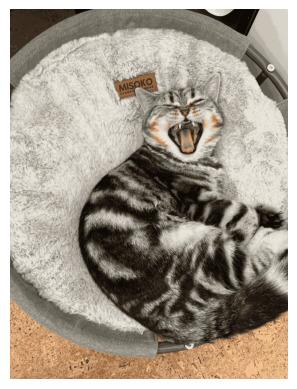

In [123]:
image_16 = kmeans_quantization(image, 16)
plt.imshow(image_16)
plt.axis("off")

#### Image quantization with a depth of 8

(-0.5, 3023.5, 4031.5, -0.5)

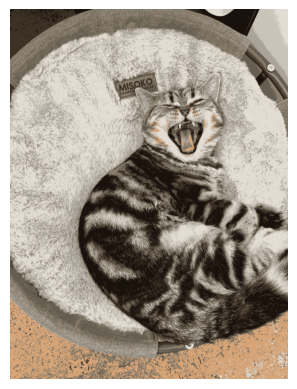

In [124]:
image_8 = kmeans_quantization(image, 8)
plt.imshow(image_8)
plt.axis("off")

### 3. Processing and classification of text data

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

#### Download a text dataset (with class labels)

In [27]:
dataset = pd.read_csv("amazon.csv")
dataset.head()

,label,text
0,__label__2,Great CD: My lovely Pat has one of the GREAT v...
1,__label__2,One of the best game music soundtracks - for a...
2,__label__1,Batteries died within a year ...: I bought thi...
3,__label__2,works fine but Maha Energy is better: Check ou...
4,__label__2,Great for the non-audiophile: Reviewed quite a...


In [26]:
dataset = dataset.dropna()
dataset.label.value_counts()

label
__label__2    112
__label__1     87
Name: count, dtype: int64

#### Refine the data (remove stop words, punctuation), use wordcloud to visualize the most common words or n-grams in each class.

In [30]:
stop_words = stopwords.words('english')
def text_preprocessing(text):
    text = text.lower()
    wordnet_lemmatizer = WordNetLemmatizer()
    word_tokens = re.split(r'\W+', text)

    # Remove stop words
    filtered_tokens = [token for token in word_tokens if token not in stop_words]

    # Remove punctuation, extra spaces, and non-Latin characters
    cleaned_text = ' '.join(filtered_tokens)
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', cleaned_text)
    cleaned_text = re.sub(r'\s{2,}', ' ', cleaned_text)

    # Lemmatize the words
    lemmatized_text = ' '.join([wordnet_lemmatizer.lemmatize(token) for token in cleaned_text.split()])
    
    return lemmatized_text

dataset['text'] = dataset['text'].apply(text_preprocessing)

#### Visualize the most common words

##### Label 1

(-0.5, 399.5, 199.5, -0.5)

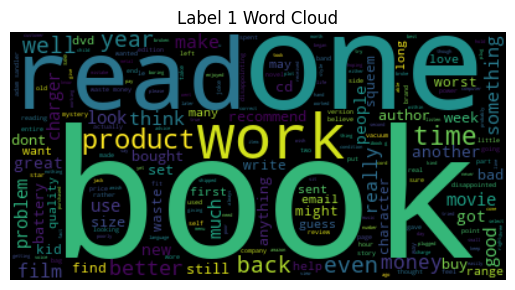

In [45]:
label1 = ' '.join(dataset[dataset.label == '__label__1'].text.tolist())
label1 = WordCloud().generate(label1)

plt.imshow(label1, interpolation='bilinear')
plt.title('Label 1 Word Cloud')
plt.axis('off')

##### Label 2

(-0.5, 399.5, 199.5, -0.5)

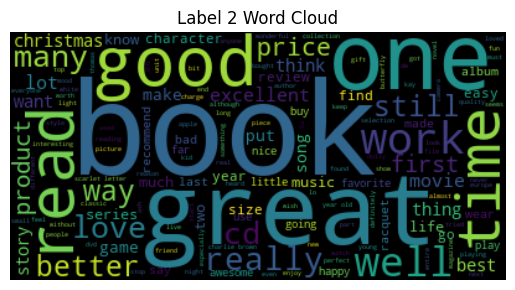

In [44]:
label2 = ' '.join(dataset[dataset.label == '__label__2'].text.tolist())
label2 = WordCloud().generate(label2)

plt.imshow(label2, interpolation='bilinear')
plt.title('Label 2 Word Cloud')
plt.axis('off')


#### Classify text data